Download packages

In [37]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
from sklego.meta import OrdinalClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from itertools import cycle, islice
import matplotlib.patches as mpatches
from sklearn.cluster import HDBSCAN, OPTICS, DBSCAN
import scipy
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.metrics import balanced_accuracy_score
import random


In [38]:
random.seed(8)

Create new feature names to take the mean and std across epochs pr person

In [39]:
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]

Concatenate data

In [40]:
path ='CSV_features_NEW/'
folder = os.fsencode(path)
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]

patient_numbers = []
r_data = []
m_data = []
f_data = []

all_data = []

for file in os.listdir(folder):
    filename = os.fsdecode(file)
    patient_numbers.append(filename[0:3])
    fname = path + filename
    data = pd.read_csv(fname)
    data.columns = renamed_markers_list
    sklearn.preprocessing.StandardScaler().set_output(transform='pandas') 
    data[m_list] = sklearn.preprocessing.StandardScaler().fit(data[m_list]).transform(data[m_list]) #standardising data within each patient
    
    all_data.append(data)

In [41]:
#fit pca across patients
data_for_pca = pd.concat(all_data)
pca = sklearn.decomposition.PCA(n_components=0.95)
components = pca.fit(data_for_pca[m_list]).components_

Inspecting optimal number of components to use

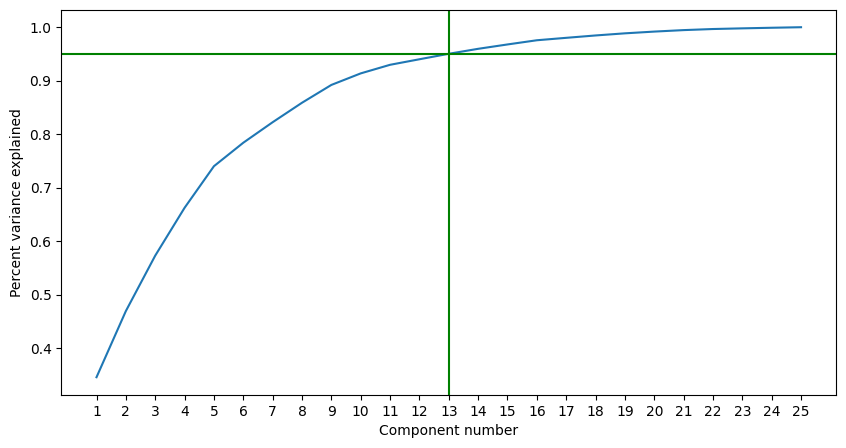

In [198]:
#done with all components
exp_var = pca.explained_variance_ratio_
plt.figure(figsize = (10, 5))
plt.plot(np.arange(1,26,1), exp_var.cumsum())
plt.xticks(np.arange(1,26,1))
plt.xlabel('Component number')
plt.ylabel('Percent variance explained')
plt.axvline(13, color='g')
plt.axhline(0.95, color='g')

Ignore irrelevant warnings

In [42]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

Forward feature selection for each person to find relevant features

In [43]:
components_n = components.shape[0]
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)
feat_scores = np.zeros((components_n, components_n))
best_comp = []
count = 1
all_scores = np.empty((components_n, len(all_data), components_n, 3))
improving = True

# Finding first optimal component to choose
for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    for j in range(components_n):
        skf = StratifiedKFold(n_splits=3)
        scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,j]).reshape(-1, 1), np.array(train_y), cv = skf, scoring='balanced_accuracy')
        score = scores.mean()
        feat_scores[0,j] += score
        all_scores[0, i, j, :] = scores

prev_score = np.max(feat_scores[0])
best_comp.append(np.argmax(feat_scores[0]))

# Looping through all combinations of features
while improving:
    for i in range(len(all_data)):
        train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
        train_X = all_data[i][m_list]
        train_X = pca.transform(train_X)
        train_X = pd.DataFrame(train_X)
        ord_clf = OrdinalClassifier(estimator=LogisticRegression())
        
        for j in range(components_n):
            if j not in best_comp:
                skf = StratifiedKFold(n_splits=3)
                scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,best_comp+[j]]), np.array(train_y), cv = skf, scoring='balanced_accuracy')
                score = scores.mean()
                feat_scores[count, j] += score
                all_scores[count, i,j,:] = scores
            
    new_score = np.max(feat_scores[count])
    
    # Checking if improvenet is small enough to terminate
    if new_score - prev_score < 0.1:
        improving = False
    else:
        # Resetting the best score and looping again
        prev_score = new_score
        best_comp.append(np.argmax(feat_scores[count]))
    count += 1

print('Final best components: ', best_comp)


Final best components:  [6, 0, 12, 1, 7]


In [44]:
# Inspecting components
for i in range(len(best_comp)):
    feature = best_comp[i]
    sort = np.argsort(abs(np.array(components[feature])))[::-1]
    feature_list = [(m_list[j], components[feature][j]) for j in sort[0:11]]

    #print(feature_list)

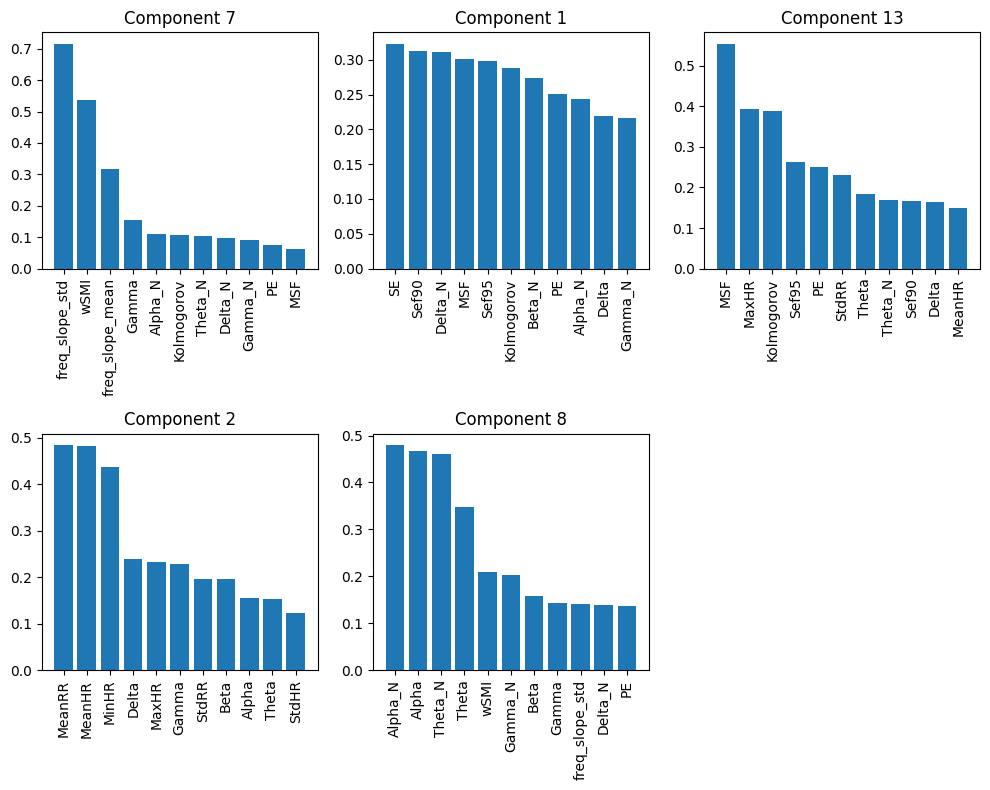

In [45]:
fig, axes = plt.subplots(2,3, figsize=(10,8))
for i,ax in zip(range(len(best_comp)),axes.ravel()):
    feature = best_comp[i]
    sort = np.argsort(abs(np.array(components[feature])))[::-1]
    feature_names = [m_list[j] for j in sort[0:11]]
    feature_imp = [abs(components[feature][j]) for j in sort[0:11]]
    ax.bar(x=feature_names, height=feature_imp)
    ax.set_xticks(ticks=range(0,11), rotation=90, labels=feature_names)
    ax.set_title('Component ' + str(best_comp[i] +1)) # Not null-indexed

fig.delaxes(axes[1][2])
plt.tight_layout()

## Performing cross validation to find responders

In [46]:
outer_loops = 3
inner_loops = 3
cv_v2_scores = np.zeros((len(all_data), outer_loops, inner_loops))

for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    comp = best_comp
    for j in range(outer_loops):
        skf = StratifiedKFold(n_splits=inner_loops, random_state=j, shuffle=True)
        scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,best_comp]), np.array(train_y), cv = skf, scoring='balanced_accuracy')
        cv_v2_scores[i, j, :] = scores

In [118]:
# Inspecting responders from t-test
import scipy.stats


B = set()
zu = []
rh_liste = []
o2_liste = []

for count, i in enumerate(cv_v2_scores):
    j = 5
    k = 3
    df = j-1
    rho = 1/k

    rand_err = 2/3
    rj = np.mean((1-i)-rand_err, axis=0)
    rh = np.mean(rj)
    rh_liste.append(rh)

    s = 0

    for e in rj:
        s += (e-rh)**2
    
    s2 = 1/(j-1) * s
    o2 = (1/j + rho/(1-rho)) * s2
    o2_liste.append(o2)
    
    zu.append(scipy.stats.t.ppf(1-0.05, df, rh, np.sqrt(o2))) # upper bound confidence interval
    t = rh/(np.sqrt(o2))
    p = scipy.stats.t.cdf(t, df)
    if p <= 0.05:
        #print(count, patient_numbers[count], p)
        B.add(count)

print('Correlated t-test responders: ', sorted(B), len(B))

Correlated t-test responders:  [4, 9, 20, 22, 31, 40, 44, 54, 55, 61] 10


In [119]:
responders = []
non_responders = []
B = sorted(B)

for i in range(len(all_data)):
    if i in B:
        responders.append([np.mean(1-cv_v2_scores[i,:]), np.std(np.mean(1-cv_v2_scores[i,:], axis=0))/np.sqrt(3), zu[i], rh_liste[i], o2_liste[i]])
    else:
        non_responders.append([np.mean(1-cv_v2_scores[i,:]), np.std(np.mean(1-cv_v2_scores[i,:], axis=0))/np.sqrt(3), zu[i], rh_liste[i], o2_liste[i]])

# Group sizes
print('Number of responders: ', len(responders))
print('Number of non-responders: ', len(non_responders))

Number of responders:  10
Number of non-responders:  63


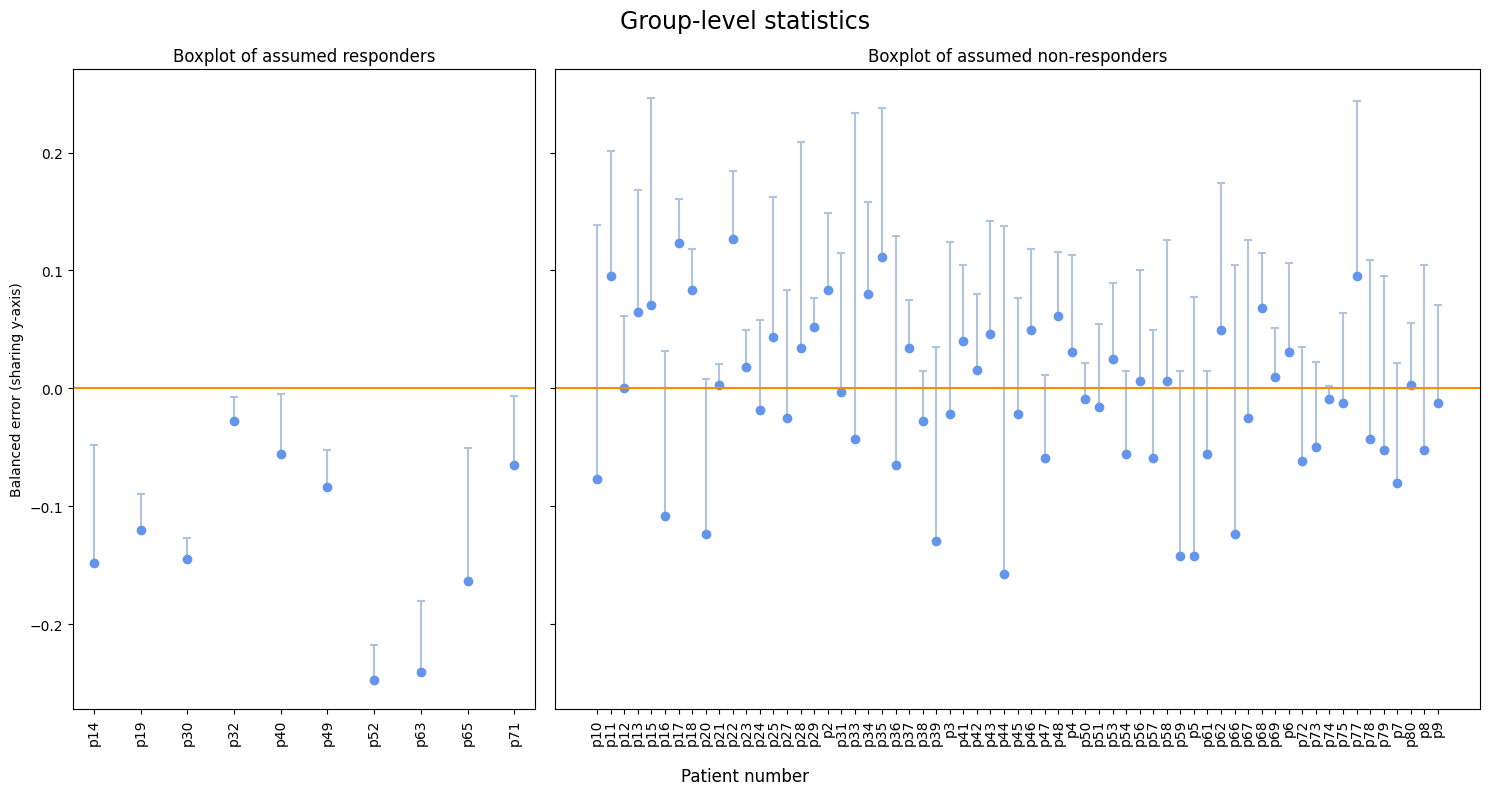

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8), gridspec_kw={'width_ratios':[1,2]})

means_r = []
std_r = []
zu_r = []
rh_r = []
o2_r = []

means_nr = []
std_nr = []
zu_nr = []
rh_nr = []
o2_nr = []

for i in responders:
    means_r.append(i[0])
    std_r.append(i[1])
    zu_r.append(i[2])
    rh_r.append(i[3])
    o2_r.append(np.sqrt(i[4])/np.sqrt(3))

for j in non_responders:
    means_nr.append(j[0])
    std_nr.append(j[1])
    zu_nr.append(j[2])
    rh_nr.append(j[3])
    o2_nr.append(np.sqrt(j[4])/np.sqrt(3))

#ax1.errorbar(x=range(len(responders)), y=rh_r, yerr=o2_r, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')
#ax2.errorbar(x=range(len(non_responders)), y=rh_nr, yerr=o2_nr, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')



ax1.vlines(x=range(len(responders)), ymin=rh_r, ymax=zu_r, colors='lightsteelblue', zorder=0)
ax2.vlines(x=range(len(non_responders)), ymin=rh_nr, ymax=zu_nr, colors='lightsteelblue', zorder=0)

ax1.scatter(x=range(len(responders)), y=rh_r, c='cornflowerblue', zorder=1)
ax2.scatter(x=range(len(non_responders)), y=rh_nr, c='cornflowerblue', zorder=1)

ax1.scatter(x=range(len(responders)), y=zu_r, c='lightsteelblue', zorder=1, marker='_')
ax2.scatter(x=range(len(non_responders)), y=zu_nr, c='lightsteelblue', zorder=1, marker='_')

ax1.axhline(0, c='darkorange')
ax2.axhline(0, c='darkorange')
ax1.set_title('Boxplot of assumed responders')
ax2.set_title('Boxplot of assumed non-responders')
ax1.set_ylabel('Balanced error (sharing y-axis)')
#ax2.set_xlabel('Patient number')
ax1.set_xticks(range(len(B)), [patient_numbers[i].strip('_') for i in B], rotation=90)
ax2.set_xticks(range(len(all_data)-len(B)), [patient_numbers[i].strip('_') for i in range(len(all_data)) if i not in B], rotation=90)
fig.suptitle('Group-level statistics', fontsize='17')
fig.supxlabel('Patient number')
plt.tight_layout()
plt.show()

# Clustering begin

In [121]:
r_data = []
m_data = []
f_data = []
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]

for data in all_data:
    R_indicesToKeep = data['Event'] == 'R'
    df_r = data.loc[R_indicesToKeep]

    M_indicesToKeep = data['Event'] == 'M'
    df_m = data.loc[M_indicesToKeep]

    F_indicesToKeep = data['Event'] == 'F'
    df_f = data.loc[F_indicesToKeep]

    r_mean = pd.DataFrame(df_r[m_list].mean(axis=0)).transpose()
    m_mean = pd.DataFrame(df_m[m_list].mean(axis=0)).transpose()
    f_mean = pd.DataFrame(df_f[m_list].mean(axis=0)).transpose()

    r_mean.columns = mean_list
    m_mean.columns = mean_list
    f_mean.columns = mean_list

    r_std = pd.DataFrame(df_r[m_list].std(axis=0)).transpose()
    m_std = pd.DataFrame(df_m[m_list].std(axis=0)).transpose()
    f_std = pd.DataFrame(df_f[m_list].std(axis=0)).transpose()
        
    r_std.columns = std_list
    m_std.columns = std_list
    f_std.columns = std_list
    
    rest = pd.concat([r_mean,r_std],axis=1).to_numpy()
    med = pd.concat([m_mean,m_std],axis=1).to_numpy()
    fam = pd.concat([f_mean,f_std],axis=1).to_numpy()

    r_data.append(rest[0])
    m_data.append(med[0])
    f_data.append(fam[0])

In [122]:
X = [f_data[i] - r_data[i] for i in range(len(r_data))] + [m_data[i] - r_data[i] for i in range(len(r_data))]
y = [i for i in range(0,len(r_data))] + [i for i in range(0,len(r_data))]


### pca transform data

In [123]:
warnings.filterwarnings(action='ignore', category=UserWarning)
X_pca = [np.append(pca.transform(X[i][0:len(m_list)].reshape(1,-1)),pca.transform(X[i][len(m_list):].reshape(1,-1))) for i in range(len(X))]

In [124]:
X_pca_array = np.asarray(X_pca)
print(X_pca_array.shape)

(146, 26)


### take chosen components from data and fit clustering algorithms

In [125]:
b= mean_list+std_list
min_size = 5
chosen_features = best_comp
ind = [True if i in chosen_features else False for i in range(components_n)] + [True if i in chosen_features else False for i in range(components_n)]
X_pca_chosen = X_pca_array[:,ind]   
    
sclustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_pca_chosen)
sy_pred = sclustering.labels_

hdb = HDBSCAN(min_cluster_size=min_size).fit(X_pca_chosen)
hy_pred = hdb.labels_
patient_numbers2 = patient_numbers+patient_numbers

dclustering = DBSCAN(min_samples=min_size).fit(X_pca_chosen)
dy_pred = dclustering.labels_    

oclustering = OPTICS(min_samples=min_size).fit(X_pca_chosen)
oy_pred = oclustering.labels_

Plotting dendogram for HDBSCAN

In [126]:
import scipy.cluster.hierarchy as spc
#import hdbscan
#clust = hdbscan.HDBSCAN(min_cluster_size=5).fit(X_pca_chosen)
df = pd.DataFrame(hy_pred)

#pdist = spc.distance.pdist(df)
linkage = spc.linkage(df, method='ward', metric='euclidean')
idx = spc.fcluster(linkage, t=3, criterion='maxclust')


(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245]),
 [Text(5, 0, '145'),
  Text(15, 0, '142'),
  Text(25, 0, '141'),
  Text(35, 0, '140'),
  Text(45, 0, '138'),
  Text(55, 0, '136'),
  Text(65, 0, '135'),
  Text(75, 0, '132'),
  Text(85, 0, '131'),
  Text(95, 0, '128'),
  Text(105, 0, '127'),
  Text(115, 0, '126'),
  Text(125, 0, '125'),
  Text(135, 0, '(70)'),
  Text(145, 0, '144'),
  Text(155, 0, '129'),
  Text(165, 0, '(9)'),
  Text(175, 0, '143'),
  Text(185, 0, '139'),
  Text(195, 0, '137'),
  Text(205, 0, '134'),
  Text(215, 0, '133'),
  Text(225, 0, '130'),
  Text(235, 0, '122'),
  Text(245, 0, '(45)')])

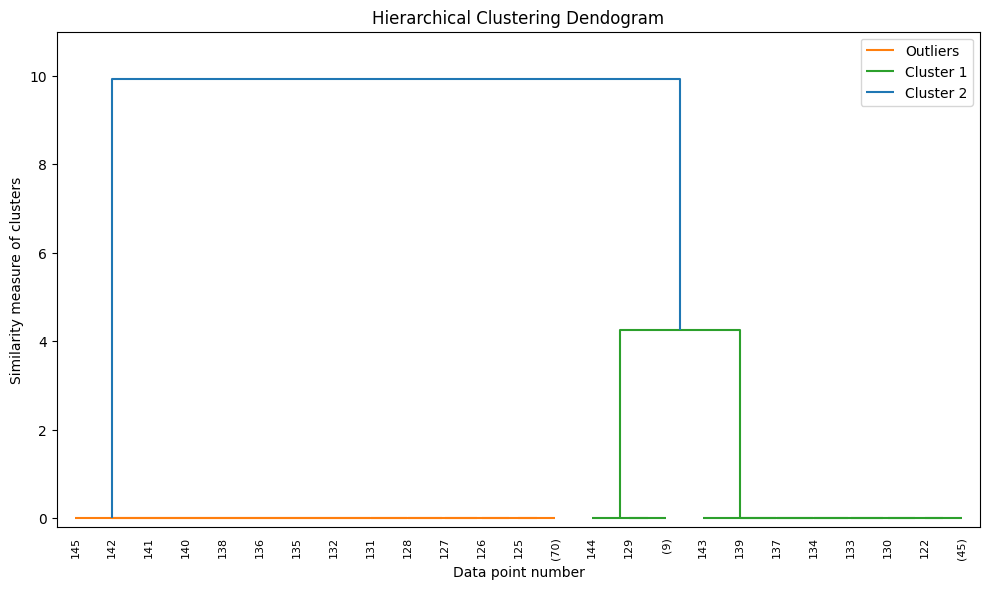

In [127]:
fig = plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendogram')
dn = spc.dendrogram(linkage, leaf_font_size=8, truncate_mode='lastp', p=25)
plt.legend(['Outliers', 'Cluster 1', 'Cluster 2'])
plt.xlabel('Data point number')
plt.ylabel('Similarity measure of clusters')
plt.ylim(-0.2,11)
plt.tight_layout()
plt.xticks(rotation=90)


In [128]:
den = np.array(dn['color_list'])
count = np.unique(den, return_counts=True)
print(count)

(array(['C0', 'C1', 'C2'], dtype='<U2'), array([ 1, 13, 10], dtype=int64))


## Plot clustering

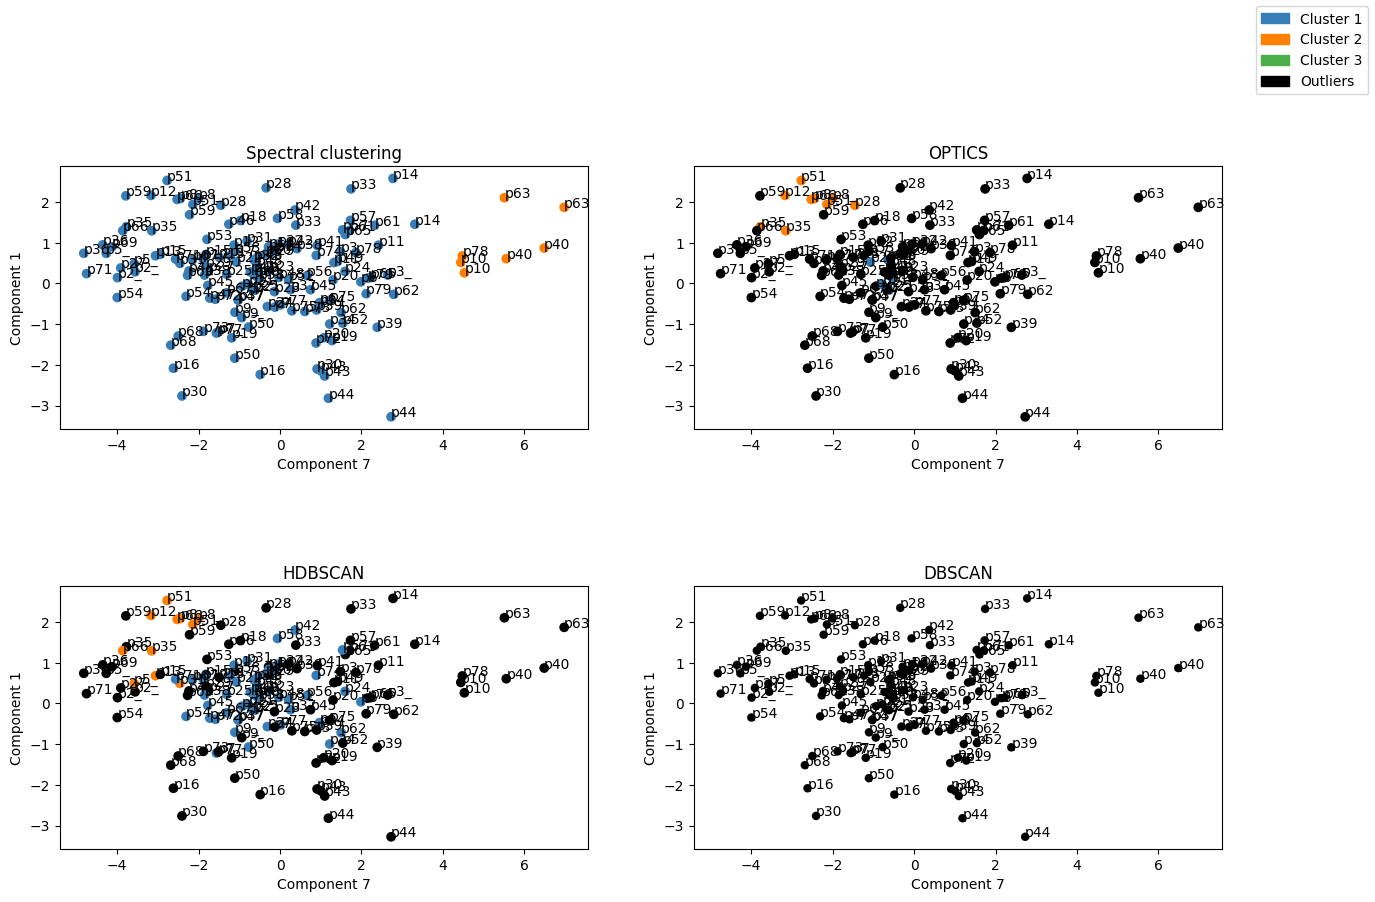

In [129]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a", 
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                ]
            ),
            int(max(np.concatenate((dy_pred, hy_pred, oy_pred, sy_pred)))+1),
        )
    )
)

# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
ax[0,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[sy_pred])
for i, txt in enumerate(y):
    ax[0,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[0,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,0].set_title('Spectral clustering')
ax[0,0].set_xlabel('Component 7')
ax[0,0].set_ylabel('Component 1')

ax[0,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[oy_pred])
for i, txt in enumerate(y):
    ax[0,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[0,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,1].set_title('OPTICS')
#ax[0,1].legend()
ax[0,1].set_xlabel('Component 7')
ax[0,1].set_ylabel('Component 1')

ax[1,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[hy_pred])
for i, txt in enumerate(y):
    ax[1,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[1,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,0].set_title('HDBSCAN')
#ax[1,0].legend()
ax[1,0].set_xlabel('Component 7')
ax[1,0].set_ylabel('Component 1')

ax[1,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, 1], c=colors[dy_pred], linewidth = 0.1)
for i, txt in enumerate(y):
    ax[1,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, 1]))
ax[1,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,1].set_title('DBSCAN')
ax[1,1].set_xlabel('Component 7')
ax[1,1].set_ylabel('Component 1')
#ax[1,1].legend()
pop_a = mpatches.Patch(color="#377eb8", label='Cluster 1') 
pop_b = mpatches.Patch(color="#ff7f00", label='Cluster 2')
pop_d = mpatches.Patch(color="#4daf4a", label='Cluster 3')
pop_c = mpatches.Patch(color="#000000", label='Outliers')
fig.legend(handles=[pop_a,pop_b,pop_d,pop_c]) 

### find different cluster groups

In [130]:
#adding wether it is familiar-resting or unfamiliar-resting datapoint
patient_numbers_with_event = [patient_num +'-fr' for patient_num in patient_numbers] + [patient_num +'-mr' for patient_num in patient_numbers] 

In [131]:
#finding each label for each patient
sy_groups = [(sy_pred[i], patient_numbers_with_event[i]) for i in range(len(sy_pred))]
oy_groups = [(oy_pred[i], patient_numbers_with_event[i]) for i in range(len(oy_pred))]
hy_groups = [(hy_pred[i], patient_numbers_with_event[i]) for i in range(len(hy_pred))]
dy_groups = [(dy_pred[i], patient_numbers_with_event[i]) for i in range(len(dy_pred))]

In [133]:
#cluster sizes
sy_groups_counts = list(zip(*np.unique(sy_pred, return_counts=True)))
oy_groups_counts = list(zip(*np.unique(oy_pred, return_counts=True)))
hy_groups_counts = list(zip(*np.unique(hy_pred, return_counts=True)))
dy_groups_counts = list(zip(*np.unique(dy_pred, return_counts=True)))
print('Spectral: ', sy_groups_counts)
print('Optics: ', oy_groups_counts)
print('HDBSCAN: ', hy_groups_counts)
print('DBSCAN: ', dy_groups_counts)

Spectral:  [(0, 139), (1, 7)]
Optics:  [(-1, 132), (0, 5), (1, 9)]
HDBSCAN:  [(-1, 83), (0, 52), (1, 11)]
DBSCAN:  [(-1, 146)]


In [135]:
#cluster sorted
sort_sy = sorted(sy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_oy = sorted(oy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_hy = sorted(hy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_dy = sorted(dy_groups, key = lambda x: (x[0],x[1]))[::-1]
#print(sort_sy)
#print(sort_oy)
#print(sort_hy)
#print(sort_dy)

In [140]:
s_small = [i for i in sy_groups if i[0] == 1]
print(len(s_small))
print(s_small)

7
[(1, 'p10-fr'), (1, 'p40-fr'), (1, 'p63-fr'), (1, 'p10-mr'), (1, 'p40-mr'), (1, 'p63-mr'), (1, 'p78-mr')]


### Plot patients that are in smaller group from spectral

In [141]:
#outliers_dy = [(-1, 'p9_-mr'), (-1, 'p8_-mr'), (-1, 'p80-mr'), (-1, 'p80-fr'), (-1, 'p7_-mr'), (-1, 'p7_-fr'), (-1, 'p79-mr'), (-1, 'p79-fr'), (-1, 'p78-mr'), (-1, 'p78-fr'), (-1, 'p73-mr'), (-1, 'p67-mr'), (-1, 'p67-fr'), (-1, 'p66-mr'), (-1, 'p63-mr'), (-1, 'p63-fr'), (-1, 'p62-fr'), (-1, 'p61-fr'), (-1, 'p60-mr'), (-1, 'p60-fr'), (-1, 'p5_-fr'), (-1, 'p58-mr'), (-1, 'p58-fr'), (-1, 'p57-mr'), (-1, 'p57-fr'), (-1, 'p56-mr'), (-1, 'p56-fr'), (-1, 'p54-mr'), (-1, 'p53-fr'), (-1, 'p52-mr'), (-1, 'p51-fr'), (-1, 'p49-mr'), (-1, 'p49-fr'), (-1, 'p48-mr'), (-1, 'p46-mr'), (-1, 'p46-fr'), (-1, 'p44-mr'), (-1, 'p44-fr'), (-1, 'p41-mr'), (-1, 'p40-mr'), (-1, 'p3_-mr'), (-1, 'p3_-fr'), (-1, 'p35-fr'), (-1, 'p34-mr'), (-1, 'p34-fr'), (-1, 'p33-mr'), (-1, 'p32-mr'), (-1, 'p32-fr'), (-1, 'p31-mr'), (-1, 'p31-fr'), (-1, 'p30-mr'), (-1, 'p30-fr'), (-1, 'p28-fr'), (-1, 'p27-mr'), (-1, 'p27-fr'), (-1, 'p22-mr'), (-1, 'p22-fr'), (-1, 'p21-mr'), (-1, 'p21-fr'), (-1, 'p20-mr'), (-1, 'p20-fr'), (-1, 'p19-mr'), (-1, 'p19-fr'), (-1, 'p18-fr'), (-1, 'p17-mr'), (-1, 'p17-fr'), (-1, 'p16-fr'), (-1, 'p15-fr'), (-1, 'p14-fr'), (-1, 'p12-fr'), (-1, 'p10-mr'), (-1, 'p10-fr')]
patient_data_pca = []
patients_in_group = []
patients_in_group_counts = []
for _, patient in s_small:
    patient = patient[:3]
    patients_in_group_counts.append(patient)
    if patient not in patients_in_group:
        patients_in_group.append(patient)
        patient_ind = patient_numbers.index(patient)
        train_X = all_data[patient_ind][m_list]
        train_X = pca.transform(train_X)
        train_X = pd.DataFrame(train_X)
        patient_data_pca.append(train_X)

patients_in_group_counts = list(zip(*np.unique(patients_in_group_counts, return_counts=True)))
sort_p_counts = sorted(patients_in_group_counts, key = lambda x: x[1])[::-1]
print(sort_p_counts)

[('p63', 2), ('p40', 2), ('p10', 2), ('p78', 1)]


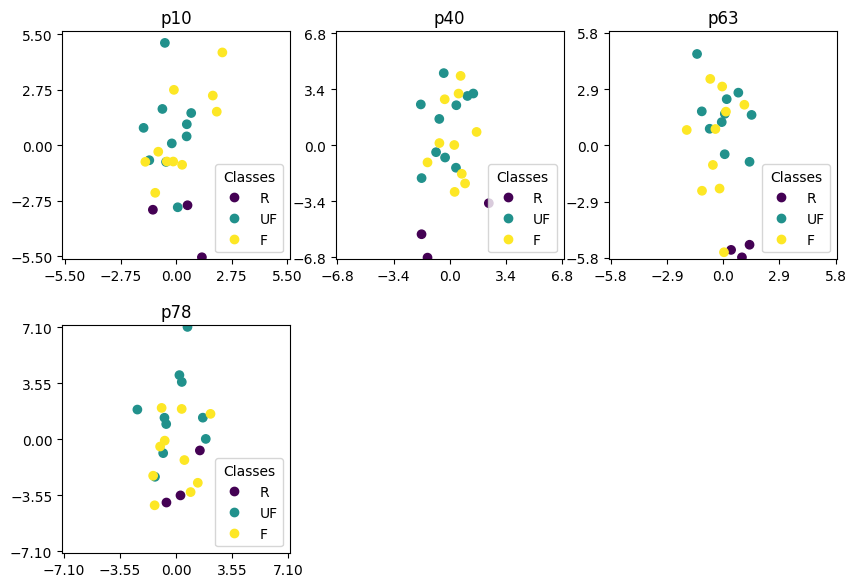

In [165]:
fig, axes = plt.subplots(2,3, figsize=(10,7))
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

for i,ax in zip(range(len(patients_in_group)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)

    scatter = ax.scatter(patient_data_pca[i][best_comp[0]], patient_data_pca[i][best_comp[1]], c=y1)
    max_val = np.max(np.append(abs(patient_data_pca[i][best_comp[0]]),abs(patient_data_pca[i][best_comp[1]]))) 
    ax.set_ylim(-max_val-0.1,max_val+0.1)
    ax.set_xlim(-max_val-0.1,max_val+0.1)
    ax.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    ax.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])

    ax.set_aspect('equal', adjustable=None, anchor=None, share=False)
    ax.legend(scatter.legend_elements()[0], ['R', 'UF', 'F'], title="Classes", loc = 'lower right')
    ax.set_title(patients_in_group[i])

fig.delaxes(axes[1][2])
fig.delaxes(axes[1][1])
